In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.activations import linear, relu, sigmoid


from keras.datasets import mnist

from my_utils import calculate_metrics, set_seed


np.set_printoptions(precision = 1)



2024-06-18 12:30:42.487953: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/damanr/Desktop/myprojectA/lib/python3.8/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
print(f'The shape of the training example features (X_train): {X_train.shape}')
print(f'The shape of the training example labels   (y_train): {y_train.shape}', end = '\n\n')

print(f'The shape of the test example features (X_test): {X_test.shape}')
print(f'The shape of the test example labels   (y_test): {y_test.shape}')



The shape of the training example features (X_train): (60000, 28, 28)
The shape of the training example labels   (y_train): (60000,)

The shape of the test example features (X_test): (10000, 28, 28)
The shape of the test example labels   (y_test): (10000,)


In [4]:
# Create a cross validation set from the training data to assist in model architecture selection and hyperparameter tuning
cross_validation_size = 10000

X_cv, y_cv = X_train[len(X_train) - cross_validation_size:] , y_train[len(y_train) - cross_validation_size:]
X_train , y_train = X_train[:len(X_train) - cross_validation_size] , y_train[:len(y_train) - cross_validation_size]

print(f'The shape of the validation set features (X_cv): {X_cv.shape}')
print(f'The shape of the validation set labels   (y_cv): {y_cv.shape}', end = '\n\n')

print(f'New shape of the training example features (X_train): {X_train.shape}')
print(f'New shape of the training example labels   (y_train): {y_train.shape}', end = '\n\n')



The shape of the validation set features (X_cv): (10000, 28, 28)
The shape of the validation set labels   (y_cv): (10000,)

New shape of the training example features (X_train): (50000, 28, 28)
New shape of the training example labels   (y_train): (50000,)



In [5]:
#Visualize data structure
print('First 3 Training Examples',X_train[:3],sep = '\n',end = '\n\n\n')
print('Target Labels',y_train[:3],sep = '\n')

First 3 Training Examples
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


Target Labels
[5 0 4]


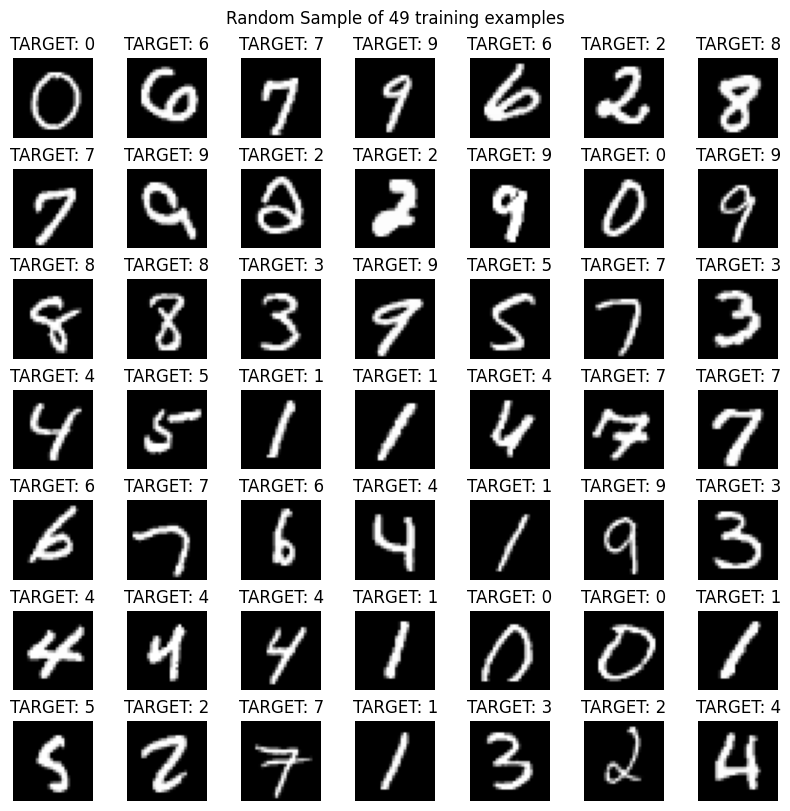

In [6]:
# View a random sampling of data
rows = 7
columns = 7 


random_indices = np.random.choice(a = len(X_train) , size = rows * columns, replace = False)

fig, axes = plt.subplots(rows,columns, constrained_layout = True)

fig.set_size_inches(8,8,forward = True)
fig.set_dpi(100)


train_count = 0
for i in range(7):
    for j in range(7):
        axes[i,j].imshow(X_train[random_indices[train_count]], cmap = 'gray')
        axes[i,j].set_title(f'TARGET: {y_train[random_indices[train_count]]}')
        axes[i,j].axis('off')
        train_count+=1

fig.suptitle(f'Random Sample of {rows * columns} training examples')

plt.show()
        

In [7]:
# Convert 28 x 28 grids of pixes to 1-D array holding sequential pixel intensities
X_train = X_train.reshape(-1,X_train.shape[1] * X_train.shape[2])
X_cv = X_cv.reshape(-1,X_cv.shape[1] * X_cv.shape[2])

X_test = X_test.reshape(-1,X_test.shape[1] * X_test.shape[2])

print(f'Finalized model input feature shape for X_train: {X_train.shape}')
print(f'Finalized model input feature shape for X_cv: {X_cv.shape}')
print(f'Finalized model input feature shape for X_test: {X_test.shape}')

Finalized model input feature shape for X_train: (50000, 784)
Finalized model input feature shape for X_cv: (10000, 784)
Finalized model input feature shape for X_test: (10000, 784)


## Creating Baseline Model 
It may be interesting to create a weak learner model that is essentially logistic regression. 
I will achieve this by creating a basic neural network with NO hidden layers, performing a classic logistic regression problem. 
This will act as a baseline to improve from. 

Performance metrics that will be analyzed:
1. Cost Function (Error Misclassified)
2. F_1 Score
   

In [8]:
def create_baseline_model():
    set_seed(23)
    baseline_model = Sequential([
    
        tf.keras.Input(shape = (X_train.shape[1])),
    
        Dense(units = 10, activation = 'linear', name = 'baseline_output')
    
    ], name = 'baseline_model')
    return baseline_model


baseline_model = create_baseline_model()

In [9]:
baseline_model.summary()

Model: "baseline_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 baseline_output (Dense)     (None, 10)                7850      
                                                                 
Total params: 7850 (30.66 KB)
Trainable params: 7850 (30.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
baseline_model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
)

# batch_size was increase to allow for slightly faster computation speed per epoch
epoch_progress = baseline_model.fit(X_train, y_train, epochs = 50,verbose = 1,batch_size = 32)

Epoch 1/50
1563/1563 [==============================] - 2s 975us/step - loss: 29.6499
Epoch 2/50
1563/1563 [==============================] - 2s 1ms/step - loss: 8.7257
Epoch 3/50
1563/1563 [==============================] - 2s 1ms/step - loss: 6.4495
Epoch 4/50
1563/1563 [==============================] - 2s 1ms/step - loss: 5.3113
Epoch 5/50
1563/1563 [==============================] - 2s 1ms/step - loss: 4.6096
Epoch 6/50
1563/1563 [==============================] - 1s 952us/step - loss: 4.0796
Epoch 7/50
1563/1563 [==============================] - 2s 1ms/step - loss: 3.6959
Epoch 8/50
1563/1563 [==============================] - 2s 1ms/step - loss: 3.3930
Epoch 9/50
1563/1563 [==============================] - 1s 914us/step - loss: 3.1104
Epoch 10/50
1563/1563 [==============================] - 2s 1ms/step - loss: 2.8950
Epoch 11/50
1563/1563 [==============================] - 2s 1ms/step - loss: 2.6992
Epoch 12/50
1563/1563 [==============================] - 2s 1ms/step - loss: 2

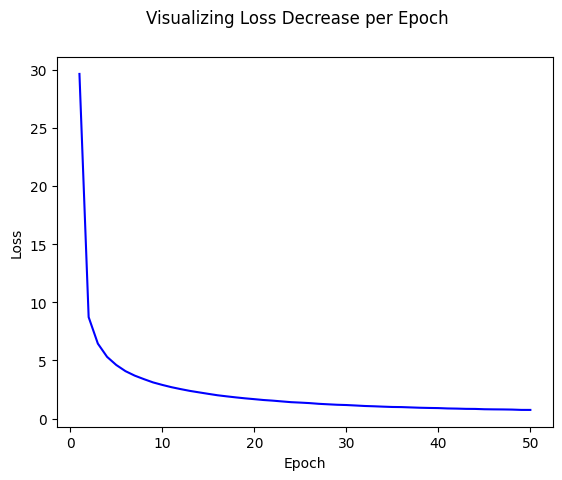

In [11]:
# Plot training curve to ensure accurate decrease of loss per epoch.
# Done to avoid divergence of gradient descent
losses = epoch_progress.history['loss']

plt.close('all')
fig, ax = plt.subplots()

fig.suptitle('Visualizing Loss Decrease per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.plot(range(1,len(losses)+1), losses, color = 'blue')


The Loss curve above shows signs of continuous decrease, confirming that an appropriate learning rate has been choosen for the baseline model.

NOTE: For the baseline model, a manual grid search approach will be carried out to optimize the parameters. For the later models a more efficient library will be used for hyperparameter tuning. 

### Baseline Model Performance
Due to the educational nature of this personal project, the metric calculations will be done by hand to demonstrate understanding of key concepts. 
In practice, a library such as sklearn will be used.

In [12]:
metrics = calculate_metrics(baseline_model, X_cv , y_cv)



313/313 [==============================] - 0s 1ms/step
baseline_model's ACCURACY             :0.896

baseline_model's ERROR                :0.104

baseline_model's PRECISION (per class):[0.928, 0.962, 0.875, 0.818, 0.843, 0.847, 0.95, 0.902, 0.912, 0.943]

baseline_model's RECALL (per class):[0.928, 0.962, 0.875, 0.818, 0.843, 0.847, 0.95, 0.902, 0.912, 0.943]

baseline_model's F1 Score (average):0.894


Naturally, the performance of the baseline model is fairly poor. Missclassifying ~ 10% of the cross validation dataset.

### Manual Hyperparameter Tuning for Baseline Model
Results above are for the following hyperparameters:
Learning Rate: 0.0001
Epochs = 50
Batch Size = 32 (default)

In [13]:
learning_rates = [0.000001, 0.00001, 0.0001, 0.001, 0.01]
epochs = [25, 50, 100, 200 , 400]
batch_sizes = [16, 32, 64, 128, 256]

models_learning_rate =[]
models_epochs =[]
models_bs = []

model_watch = 0
for lr in learning_rates:
    baseline_model_learning = create_baseline_model()
    
    baseline_model_learning.compile(
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
        optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
    )

    baseline_model_learning.fit(X_train, y_train, epochs = 50,verbose = 0,batch_size = 32)
    print(f'DONE TRAINING MODEL: {model_watch} ')
    models_learning_rate.append(baseline_model_learning)
    model_watch+=1
    


DONE TRAINING MODEL: 0 
DONE TRAINING MODEL: 1 
DONE TRAINING MODEL: 2 
DONE TRAINING MODEL: 3 
DONE TRAINING MODEL: 4 


In [14]:
metrics_cv = []
metrics_train = []
for model in models_learning_rate:
    metrics_cv.append(calculate_metrics(model,X_cv,y_cv))
    metrics_train.append(calculate_metrics(model,X_train,y_train))


313/313 [==============================] - 1s 1ms/step
baseline_model's ACCURACY             :0.754

baseline_model's ERROR                :0.246

baseline_model's PRECISION (per class):[0.885, 0.889, 0.745, 0.685, 0.765, 0.621, 0.872, 0.807, 0.618, 0.647]

baseline_model's RECALL (per class):[0.885, 0.889, 0.745, 0.685, 0.765, 0.621, 0.872, 0.807, 0.618, 0.647]

baseline_model's F1 Score (average):0.753
1563/1563 [==============================] - 2s 1ms/step
baseline_model's ACCURACY             :0.743

baseline_model's ERROR                :0.257

baseline_model's PRECISION (per class):[0.86, 0.891, 0.739, 0.682, 0.741, 0.611, 0.854, 0.8, 0.597, 0.626]

baseline_model's RECALL (per class):[0.86, 0.891, 0.739, 0.682, 0.741, 0.611, 0.854, 0.8, 0.597, 0.626]

baseline_model's F1 Score (average):0.739
313/313 [==============================] - 0s 1ms/step
baseline_model's ACCURACY             :0.882

baseline_model's ERROR                :0.118

baseline_model's PRECISION (per class):[0

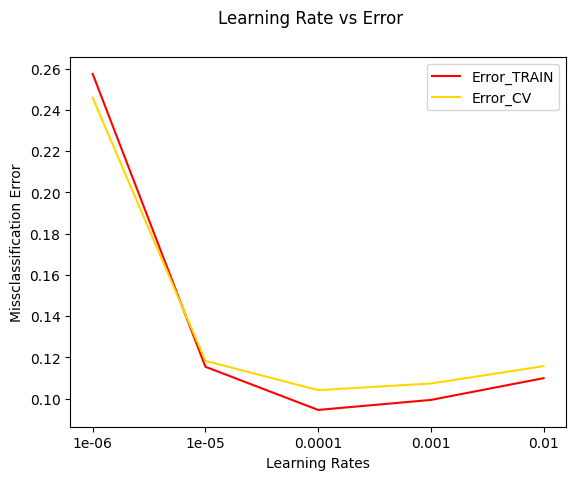

In [15]:
fig, ax = plt.subplots()
num_ticks = len(learning_rates)
evenly_spaced_ticks = np.arange(num_ticks)

ax.plot(evenly_spaced_ticks, [1- metric.accuracy for metric in metrics_train], color = 'red', label = 'Error_TRAIN')
ax.plot(evenly_spaced_ticks, [1- metric.accuracy for metric in metrics_cv], color = 'gold',label ='Error_CV')


# Set the x-axis ticks to be evenly spaced
ax.set_xticks(evenly_spaced_ticks)

# Set the labels for the ticks to be the original x_values
ax.set_xticklabels(learning_rates)
ax.set_xlabel('Learning Rates')
ax.set_ylabel('Missclassification Error')
fig.suptitle('Learning Rate vs Error')
ax.legend()
plt.show()
    

In [16]:
best_ll = np.argmin(np.array([1 - metric.accuracy for metric in metrics_cv]))
print(best_ll)

2


In [17]:
# Using best learning rate, lets find the best epoch count
model_watch = 1
for ep in epochs:
    baseline_model_epoch = create_baseline_model()
    
    baseline_model_epoch.compile(
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
        optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rates[best_ll])
    )

    baseline_model_epoch.fit(X_train, y_train, epochs = ep,verbose = 0,batch_size = 32)
    print(f'DONE TRAINING MODEL: {model_watch} ')
    models_epochs.append(baseline_model_epoch)
    model_watch+=1
    

DONE TRAINING MODEL: 1 
DONE TRAINING MODEL: 2 
DONE TRAINING MODEL: 3 
DONE TRAINING MODEL: 4 
DONE TRAINING MODEL: 5 


In [18]:
metrics_cv = []
metrics_train = []
for model in models_epochs:
    metrics_cv.append(calculate_metrics(model,X_cv,y_cv))
    metrics_train.append(calculate_metrics(model,X_train,y_train))

313/313 [==============================] - 0s 754us/step
baseline_model's ACCURACY             :0.891

baseline_model's ERROR                :0.109

baseline_model's PRECISION (per class):[0.955, 0.928, 0.909, 0.834, 0.933, 0.823, 0.902, 0.929, 0.899, 0.804]

baseline_model's RECALL (per class):[0.955, 0.928, 0.909, 0.834, 0.933, 0.823, 0.902, 0.929, 0.899, 0.804]

baseline_model's F1 Score (average):0.890
1563/1563 [==============================] - 1s 685us/step
baseline_model's ACCURACY             :0.903

baseline_model's ERROR                :0.097

baseline_model's PRECISION (per class):[0.953, 0.944, 0.914, 0.855, 0.952, 0.839, 0.923, 0.941, 0.898, 0.821]

baseline_model's RECALL (per class):[0.953, 0.944, 0.914, 0.855, 0.952, 0.839, 0.923, 0.941, 0.898, 0.821]

baseline_model's F1 Score (average):0.902
313/313 [==============================] - 0s 763us/step
baseline_model's ACCURACY             :0.896

baseline_model's ERROR                :0.104

baseline_model's PRECISION (p

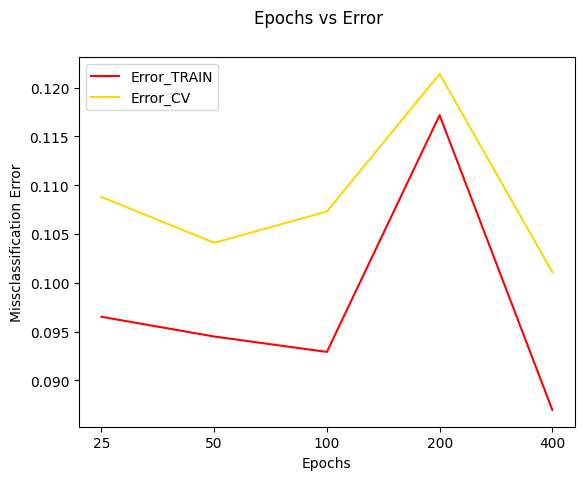

In [19]:
fig, ax = plt.subplots()
num_ticks = len(epochs)
evenly_spaced_ticks = np.arange(num_ticks)

ax.plot(evenly_spaced_ticks, [1- metric.accuracy for metric in metrics_train], color = 'red', label = 'Error_TRAIN')
ax.plot(evenly_spaced_ticks, [1- metric.accuracy for metric in metrics_cv], color = 'gold',label ='Error_CV')


# Set the x-axis ticks to be evenly spaced
ax.set_xticks(evenly_spaced_ticks)

# Set the labels for the ticks to be the original x_values
ax.set_xticklabels(epochs)
ax.set_xlabel('Epochs')
ax.set_ylabel('Missclassification Error')
fig.suptitle('Epochs vs Error')
ax.legend()
plt.show()

In [20]:
best_epoch = np.argmin(np.array([1 - metric.accuracy for metric in metrics_cv]))
print(best_epoch)

4


In [21]:
# Using best learning rate and best_epoch, lets find the best batch size
model_watch = 1
for batch in batch_sizes:
    baseline_model_bs = create_baseline_model()
    
    baseline_model_bs.compile(
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
        optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rates[best_ll])
    )

    baseline_model_bs.fit(X_train, y_train, epochs = epochs[best_epoch],verbose = 0,batch_size = batch)
    print(f'DONE TRAINING MODEL: {model_watch} ')
    models_bs.append(baseline_model_bs)
    model_watch+=1
    

DONE TRAINING MODEL: 1 
DONE TRAINING MODEL: 2 
DONE TRAINING MODEL: 3 
DONE TRAINING MODEL: 4 
DONE TRAINING MODEL: 5 


In [22]:
metrics_cv = []
metrics_train = []
for model in models_bs:
    metrics_cv.append(calculate_metrics(model,X_cv,y_cv))
    metrics_train.append(calculate_metrics(model,X_train,y_train))

313/313 [==============================] - 0s 944us/step
baseline_model's ACCURACY             :0.903

baseline_model's ERROR                :0.097

baseline_model's PRECISION (per class):[0.942, 0.956, 0.925, 0.94, 0.923, 0.833, 0.914, 0.907, 0.807, 0.895]

baseline_model's RECALL (per class):[0.942, 0.956, 0.925, 0.94, 0.923, 0.833, 0.914, 0.907, 0.807, 0.895]

baseline_model's F1 Score (average):0.902
1563/1563 [==============================] - 2s 1ms/step
baseline_model's ACCURACY             :0.915

baseline_model's ERROR                :0.085

baseline_model's PRECISION (per class):[0.954, 0.969, 0.937, 0.954, 0.926, 0.872, 0.945, 0.907, 0.783, 0.914]

baseline_model's RECALL (per class):[0.954, 0.969, 0.937, 0.954, 0.926, 0.872, 0.945, 0.907, 0.783, 0.914]

baseline_model's F1 Score (average):0.913
313/313 [==============================] - 0s 696us/step
baseline_model's ACCURACY             :0.899

baseline_model's ERROR                :0.101

baseline_model's PRECISION (per c

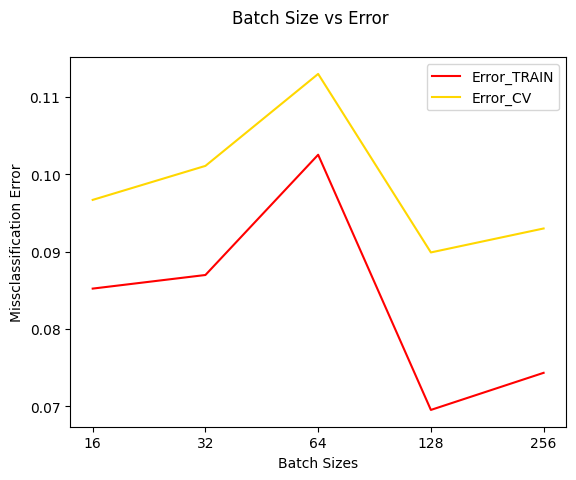

In [23]:
fig, ax = plt.subplots()
num_ticks = len(batch_sizes)
evenly_spaced_ticks = np.arange(num_ticks)

ax.plot(evenly_spaced_ticks, [1- metric.accuracy for metric in metrics_train], color = 'red', label = 'Error_TRAIN')
ax.plot(evenly_spaced_ticks, [1- metric.accuracy for metric in metrics_cv], color = 'gold',label ='Error_CV')


# Set the x-axis ticks to be evenly spaced
ax.set_xticks(evenly_spaced_ticks)

# Set the labels for the ticks to be the original x_values
ax.set_xticklabels(batch_sizes)
ax.set_xlabel('Batch Sizes')
ax.set_ylabel('Missclassification Error')
fig.suptitle('Batch Size vs Error')
ax.legend()
plt.show()

In [24]:
best_batch_size = np.argmin(np.array([1 - metric.accuracy for metric in metrics_cv]))
print(best_batch_size)

3


In [25]:
print(calculate_metrics(models_bs[best_batch_size],X_cv,y_cv))

313/313 [==============================] - 0s 772us/step
baseline_model's ACCURACY             :0.910

baseline_model's ERROR                :0.090

baseline_model's PRECISION (per class):[0.932, 0.945, 0.913, 0.931, 0.898, 0.868, 0.929, 0.921, 0.856, 0.902]

baseline_model's RECALL (per class):[0.932, 0.945, 0.913, 0.931, 0.898, 0.868, 0.929, 0.921, 0.856, 0.902]

baseline_model's F1 Score (average):0.909


In [26]:
print(calculate_metrics(baseline_model,X_cv,y_cv))

313/313 [==============================] - 0s 762us/step
baseline_model's ACCURACY             :0.896

baseline_model's ERROR                :0.104

baseline_model's PRECISION (per class):[0.928, 0.962, 0.875, 0.818, 0.843, 0.847, 0.95, 0.902, 0.912, 0.943]

baseline_model's RECALL (per class):[0.928, 0.962, 0.875, 0.818, 0.843, 0.847, 0.95, 0.902, 0.912, 0.943]

baseline_model's F1 Score (average):0.894
